<a href="https://colab.research.google.com/github/Pratham3301/Movies-Recommendation/blob/main/MRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install numpy pandas scikit-learn surprise matplotlib seaborn


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise.model_selection import GridSearchCV


In [31]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')

data = pd.merge(ratings, movies, on='movieId')


--2024-06-13 18:47:02--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  2.87MB/s    in 0.3s    

2024-06-13 18:47:04 (2.87 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
replace ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


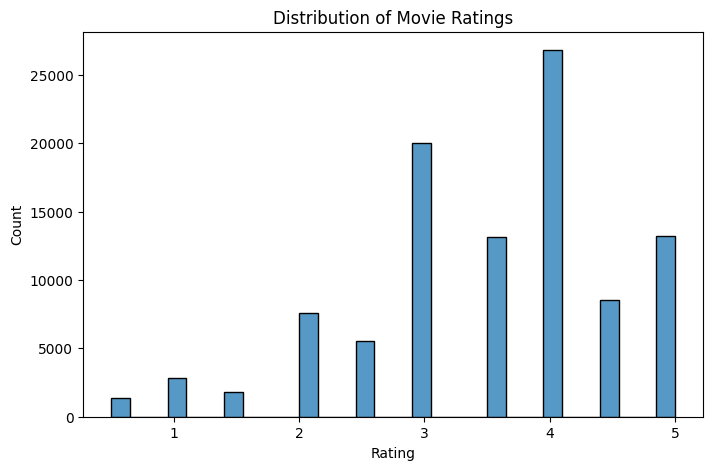

In [32]:
plt.figure(figsize=(8, 5))
sns.histplot(data['rating'], bins=30, kde=False)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


<ipython-input-33-2ebab29a0703>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=movie_ratings_count.head(20).values, y=movie_ratings_count.head(20).index, palette='viridis')


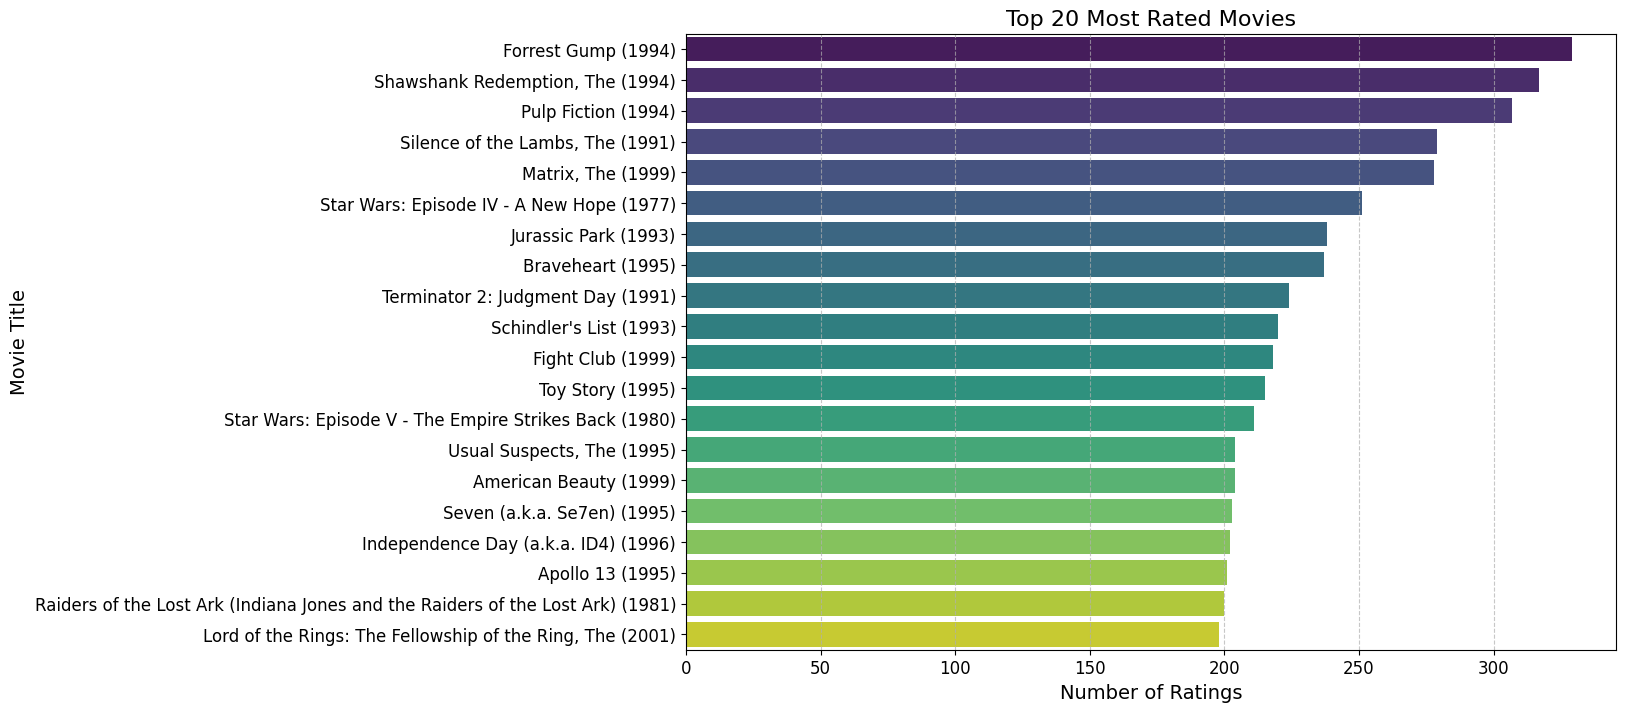

In [33]:
movie_ratings_count = data.groupby('title').size().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=movie_ratings_count.head(20).values, y=movie_ratings_count.head(20).index, palette='viridis')
plt.title('Top 20 Most Rated Movies', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=14)
plt.ylabel('Movie Title', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [34]:
reader = Reader(rating_scale=(0.5, 5.0))
dataset = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)
trainset, testset = surprise_train_test_split(dataset, test_size=0.2)


In [35]:
svd = SVD()
svd.fit(trainset)


In [36]:
predictions = svd.test(testset)
print(f'RMSE: {accuracy.rmse(predictions)}')


RMSE: 0.8688
RMSE: 0.8687902451318609


In [37]:
param_grid = {
    'n_epochs': [20],
    'lr_all': [0.002],
    'reg_all': [0.4, 0.5]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=2)
gs.fit(dataset)

print(gs.best_params['rmse'])
best_svd = gs.best_estimator['rmse']
best_svd.fit(trainset)


{'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.4}


In [38]:
def get_movie_recommendations(user_id, num_recommendations=10):
    all_movie_ids = data['movieId'].unique()

    rated_movie_ids = data[data['userId'] == user_id]['movieId'].unique()

    movie_ids_to_predict = np.setdiff1d(all_movie_ids, rated_movie_ids)
    predictions = [best_svd.predict(user_id, movie_id) for movie_id in movie_ids_to_predict]
    predictions.sort(key=lambda x: x.est, reverse=True)

    top_movie_ids = [pred.iid for pred in predictions[:num_recommendations]]
    recommended_movies = movies[movies['movieId'].isin(top_movie_ids)]
    return recommended_movies


In [41]:
user_id = 3
recommendations = get_movie_recommendations(user_id, num_recommendations=10)
recommendations


,movieId,title,genres
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
686,904,Rear Window (1954),Mystery|Thriller
694,912,Casablanca (1942),Drama|Romance
899,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
905,1203,12 Angry Men (1957),Drama
922,1221,"Godfather: Part II, The (1974)",Crime|Drama
1734,2329,American History X (1998),Crime|Drama
2226,2959,Fight Club (1999),Action|Crime|Drama|Thriller
